# Decompaction

<div class="alert alert-block alert-success">
_Learning points_: decompaction is an important procedure to remove the progressive effects of compaction and reduction of layer thicknesses and average porosities during basin subsidence. Decompaction allows the depths of certain stratigraphic horizons to be tracked as a function of time. The decompaction technique essentially restores present-day thicknesses to those at a given time in the burial history by use of porosity-depth relationships for each lithological type. </div>

## Posing the problem

The decompaction method proposed by Sclater & Christie (1980) is summarised below. Consider a sediment layer at present depths of $y_1$ and $y_2$ that is to be moved vetically to new shallower depths $y_1'$ and $y_2'$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from scipy.optimize import bisect
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['mathtext.fontset'] = 'cm'

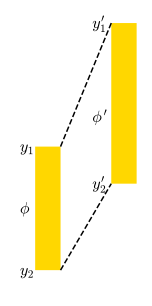

In [2]:
plt.figure(figsize=(2,5))
x = [0,1,1,0,0]
y = [1,1,1.5,1.5,1]
plt.text(-0.6,1.02,'$y_1$',fontsize=16)
plt.text(-0.6,1.52,'$y_2$',fontsize=16)
plt.text(-0.6,1.27,'$\phi$',fontsize=16)
plt.fill(x,y,'gold')
x = [3,4,4,3,3]
y = [0.5,0.5,1.15,1.15,0.5]
plt.text(2.25,0.52,'$y_1\'$',fontsize=16)
plt.text(2.25,1.17,'$y_2\'$',fontsize=16)
plt.text(2.25,0.9,'$\phi\'$',fontsize=16)
plt.fill(x,y,'gold')
plt.plot([1,3],[1,0.5],'k--')
plt.plot([1,3],[1.5,1.15],'k--')
plt.gca().invert_yaxis()
plt.axis('off');

Following  Athy's formulation for normally pressured sediments, the variation of porosity $\phi$ with depth $y$ is given by (eq. 1)

$$ \phi(y) = \phi_0 e^{-cy}$$

where $\phi_0$ is the surface porosity and $c$ is a depth constant for the downward decrease in porosity. The amount of water-filled pore space $V_w$ between depths $y_1$ and $y_2$ is simply the porosity integrated over the depth interval (eq. 2),

$$ V_w = \int^{y_2}_{y_1} \phi_0 e^{-cy} dy$$ 

The integration by u-substitution gives (eq. 3)

$$ V_w = \frac{\phi_0}{c} \left( e^{-cy_1} - e^{-cy_2}\right) $$

since the total volume of the sedimentary layer ($V_t$) is the volume due to pore-filling water ($V_w$) and the volume of the sediment grains ($V_s$) (eq. 4)

$$ V_s = V_t - V_w $$

Assuming a unit cross-sectional area, it follows that (eq. 5):

$$ y_s = y_2- y_1 - \frac{\phi_0}{c} \left( e^{-cy_1} - e^{-cy_2}\right)$$

On decompaction, the sediment volume remains the same, only the volume of water changes. The height of the water in a unit area sedimentary column lying between depths $y_1'$ and $y_2'$ is (eq. 6):


$$ y_w' = \frac{\phi_0}{c} \left( e^{-cy_1'} - e^{-cy_2'}\right)$$

The new decompacted thickness of the sediment layer is the sum of the thickness due to the sediment grains ($y_s$) and that due to the water ($y_w'$). That is (eq. 7)

$$ y_2' - y_1' = y_s + y_w' $$

which becomes (eq. 8)

$$ y_2' - y_1' =  y_2- y_1 - \frac{\phi_0}{c} \left( e^{-cy_1} - e^{-cy_2}\right) + \frac{\phi_0}{c} \left( e^{-cy_1'} - e^{-cy_2'}\right) $$

This is the **general decompaction equation**. It represents mathematicaly the exercise of sliding the sediment layer up the exponential porosity-depth curve. Its solution is by numerical iteration, which makes it ideal for solving by computer.

The average porosity of the layer at any depth is (eq. 9)

$$ \phi = \frac{\phi_0}{c} \left[\frac{e^{-cy_1'} - e^{-cy_2'}}{y_2'-y_1'}\right]$$

## Calculation of decompacted depths, layer thicknesses and average porosities

### Stage 1: decompaction of layer 1

<img src="figs/ex3-fig1.png" width="50%">

We consider the three-layer dataset defined by the above table. The procedure to decompact the different layers consist in an iterative process starting from the deepest layer to the top of the sedimentary pile.

<img src="figs/ex3-fig2.png" width="40%">

To decompact layer 1 (Chalk) so that its upper surface is at sea-level, we use eq. 8 with:
+ $y_{2-1}^{s1}$ = 4000 m corresponding to $y_2$ for layer 1 (subscript) at stage 1 (superscript)
+ $y_{1-1}^{s1}$ = 3000 m corresponding to $y_1$ for layer 1 (subscript) at stage 1 (superscript)
+ $y_{1-1}^{s1'}$ = 0 m corresponding to $y_1'$ for layer 1 (subscript) at stage 1 (superscript)
+ $\phi_0$ = 0.70
+ $c$ = 0.71

In [3]:
y2_1_s1 = 4.
y1_1_s1 = 3.
phi0_chalk = 0.7
c_chalk = 0.71

As you can see $y_2'$ appears on both the right-hand (RHS) and left-hand (LHS) sides of eq. 8. It could be solved in the ‘_brute force_’ way, that is, by gradually changing the value of $y_2'$ until RHS=LHS. 

Using the **bisection** function from **scipy** we can do it much more elegantly: 
[scipy bisect function](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.bisect.html)

To do this we first need to create the compaction function 

In [4]:
# Compaction function - the unknown variable is y2a
def comp_func(y2new,y1,y2,y1new,phi0,c):
    # left hand side of decompaction equation:
    LHS = y2new - y1new
    # right hand side of decompaction equation:
    RHS = y2 - y1 - (phi0/c)*(np.exp(-c*y1)-np.exp(-c*y2)) + (phi0/c)*(np.exp(-c*y1new)-np.exp(-c*y2new))
    return LHS - RHS

One issue we need to address is that `comp_func` six input parameters, but the scipy **bisect** function only takes one parameter. We create a partial function `comp_func_1` in which the only variable is $y_2'$ (y2new), the rest are treated as constants:

In [5]:
y1new_1_s1 = 0.
comp_func_1 = functools.partial(comp_func, y1=y1_1_s1, 
                                y2=y2_1_s1, y1new=y1new_1_s1, 
                                phi0=phi0_chalk, c=c_chalk)

In [11]:
# Use bisection to find new base depth
y2new_1_s1 = bisect(comp_func_1,y1new_1_s1,y1new_1_s1 + 3.*(y2_1_s1-y1_1_s1)) 
print('Compacted layer 1 thickness: '+str(round(y2_1_s1-y1_1_s1,4))+' km')
print '------'
print('Decompacted layer 1 base depth: '+str(round(y2new_1_s1,4))+' km')
print('Decompacted layer 1 thickness: '+str(round(y2new_1_s1-y1new_1_s1,4))+' km')

Compacted layer 1 thickness: 1.0 km
------
Decompacted layer 1 base depth: 1.6126 km
Decompacted layer 1 thickness: 1.6126 km


Now let's compute the initial and new porosity

In [8]:
# Initial average porosity
phi_1_s1 = (phi0_chalk/c_chalk)*(np.exp(-c_chalk*y1_1_s1)-np.exp(-c_chalk*y2_1_s1))/(y2_1_s1-y1_1_s1) 
# New average porosity
newphi_1_s1 = (phi0_chalk/c_chalk)*(np.exp(-c_chalk*y1new_1_s1)-np.exp(-c_chalk*y2new_1_s1))/(y2new_1_s1-y1new_1_s1) 

In [9]:
print('Compacted layer 1 porosity: '+str(round(phi_1_s1,3)))
print('Decompacted layer 1 porosity: '+str(round(newphi_1_s1,3)))

Compacted layer 1 porosity: 0.06
Decompacted layer 1 porosity: 0.417


The result is $y_{2-1}^{s1'}$ $\sim$ **1612 m**, and the average porosity of the decompacted layer 1 is **0.417**.

<img src="figs/ex3-fig3.png" width="30%">

## Stage 2: decompacting the second layer

<div class="alert alert-block alert-info">
**To track the depth of the base of layer 1 over time, it is necessary to decompact Layer 2 by bringing it to the surface, so that the decompacted base of layer 2 becomes the top of layer 1.**</div>

To decompact layer 2 (Sandstones) so that its upper surface is at sea-level, we use eq. 8 with:
+ $y_{2-2}^{s2}$ = 3000 m corresponding to $y_2$ for layer 2 (subscript) at stage 2 (superscript)
+ $y_{1-2}^{s2}$ = 2000 m corresponding to $y_1$ for layer 2 (subscript) at stage 2 (superscript)
+ $y_{1-2}^{s2'}$ = 0 m corresponding to $y_1'$ for layer 2 (subscript) at stage 2 (superscript)
+ $\phi_0$ = 0.49
+ $c$ = 0.27

In [15]:
y2_2_s2 = 3.
y1_2_s2 = 2.
phi0_sand = 0.49
c_sand = 0.27

In [18]:
y1new_2_s2 = 0.
comp_func_2 = functools.partial(comp_func, y1=y1_2_s2, 
                                y2=y2_2_s2, y1new=y1new_2_s2, 
                                phi0=phi0_sand, c=c_sand)

In [19]:
# Use bisection to find new base depth
y2new_2_s2 = bisect(comp_func_2,y1new_2_s2,y1new_2_s2 + 3.*(y2_2_s2-y1_2_s2)) 
print('Compacted layer 2 thickness: '+str(round(y2_2_s2-y1_2_s2,3))+' km')
print '------'
print('Decompacted layer 2 base depth: '+str(round(y2new_2_s2,3))+' km')
print('Decompacted layer 2 thickness: '+str(round(y2new_2_s2-y1new_2_s2,3))+' km')

Compacted layer 2 thickness: 1.0 km
------
Decompacted layer 2 base depth: 1.28 km
Decompacted layer 2 thickness: 1.28 km


In [20]:
# Initial average porosity
phi_2_s2 = (phi0_sand/c_sand)*(np.exp(-c_sand*y1_2_s2)-np.exp(-c_sand*y2_2_s2))/(y2_2_s2-y1_2_s2) 
# New average porosity
newphi_2_s2 = (phi0_sand/c_sand)*(np.exp(-c_sand*y1new_2_s2)-np.exp(-c_sand*y2new_2_s2))/(y2new_2_s2-y1new_2_s2)

In [21]:
print('Compacted layer 2 porosity: '+str(round(phi_2_s2,3)))
print('Decompacted layer 2 porosity: '+str(round(newphi_2_s2,3)))

Compacted layer 2 porosity: 0.25
Decompacted layer 2 porosity: 0.414


To track the base of layer 1 over time, it is necessary to decompact Layer 2 by bringing it to the surface. As shown, the decompacted base of layer 2 is at **1280** m and the average porosity of decompacted layer 2 is **0.414**.

### Update the first layer

Based on decompacted thickness of layer 2, the depth to the top of layer 1 is therefore 1280 m. To calculate the base of layer 1 under the decompacted layer 2 we set $y_{1-1}^{s2'}$ = 1280 m.

In [22]:
y1new_1_s2 = 1.28
y2_1_s2 = 4.
y1_1_s2 = 3.
phi0_chalk = 0.7
c_chalk = 0.71
comp_func_3 = functools.partial(comp_func, y1=y1_1_s2, 
                                y2=y2_1_s2, y1new=y1new_1_s2, 
                                phi0=phi0_chalk, c=c_chalk)

In [23]:
# Use bisection to find new base depth
y2new_1_s2 = bisect(comp_func_3,y1new_1_s2,y1new_1_s2 + 3*(y2_1_s2-y1_1_s2)) 
print('Compacted layer 1 thickness: '+str(round(y2_1_s2-y1_1_s2,4))+' km')
print '------'
print('Decompacted layer 1 base depth: '+str(round(y2new_1_s2,4))+' km')
print('Decompacted layer 1 thickness: '+str(round(y2new_1_s2-y1new_1_s2,4))+' km')

Compacted layer 1 thickness: 1.0 km
------
Decompacted layer 1 base depth: 2.4439 km
Decompacted layer 1 thickness: 1.1639 km


In [28]:
# Initial average porosity
phi_1_s2 = (phi0_chalk/c_chalk)*(np.exp(-c_chalk*y1_1_s2)-np.exp(-c_chalk*y2_1_s2))/(y2_1_s2-y1_1_s2) 
# New average porosity
newphi_1_s2 = (phi0_chalk/c_chalk)*(np.exp(-c_chalk*y1new_1_s2)-np.exp(-c_chalk*y2new_1_s2))/(y2new_1_s2-y1new_1_s2) 

In [29]:
print('Compacted layer 1 porosity: '+str(round(phi_1_s2,3)))
print('Decompacted layer 1 porosity: '+str(round(newphi_1_s2,3)))

Compacted layer 1 porosity: 0.06
Decompacted layer 1 porosity: 0.192


During stage 2, the base of the layer 1 becomes **2444** m. The average porosity of layer 1 under the decompacted layer 2 is **0.192**.

<img src="figs/ex3-fig4.png" width="40%">

## Stage 3: updating the sedimentary layers

To get the values of layer thicknesses and average porosities, we only have to compute the average porosity for the last layer:

Layer 3 (Shales) is defined by:
+ $y_{2-3}^{s3}$ = 2000 m corresponding to $y_2$ for layer 3 (subscript) at stage 3 (superscript)
+ $y_{1-3}^{s3}$ = 0 m corresponding to $y_1$ for layer 3 (subscript) at stage 3 (superscript)
+ $\phi_0$ = 0.63
+ $c$ = 0.51

In [32]:
y2_3_s3 = 2.
y1_3_s3 = 0.
phi0_shales = 0.63
c_shales = 0.51

In [33]:
# Initial average porosity
phi_3 = (phi0_shales/c_shales)*(np.exp(-c_shales*y1_3_s3)-np.exp(-c_shales*y2_3_s3))/(y2_3_s3-y1_3_s3) 
print('Layer 3 porosity: '+str(round(phi_3,3)))

Layer 3 porosity: 0.395


Layer thicknesses and average porosities calculated through the decompaction process are compiled in the graph below.


<img src="figs/ex3-fig5.png" width="50%">